In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True

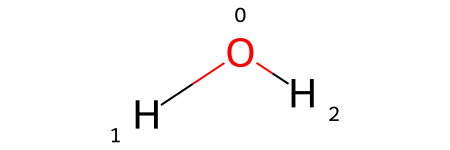

In [5]:
# generate water molecule
smiles = "O"
mol = Chem.MolFromSmiles(smiles)
mol = Chem.AddHs(mol)
Chem.AllChem.EmbedMolecule(mol)
Chem.AllChem.SetBondLength(mol.GetConformer(0), 0,1,1.5)  # for demo
Chem.MolToXYZFile(mol, "water.xyz")
mol

In [6]:
from pyscf import gto, scf
mol = gto.M(atom="water.xyz")

mol.basis = "sto3g"

mf = mol.KS()
mf.xc = 'b3lyp'
mf.kernel()

converged SCF energy = -75.1823821404357


-75.18238214043566

In [7]:
# Let's do something for sto-3g basis
import numpy as np
import matplotlib.pyplot as plt
from pyscf.gto.basis import load

In [9]:
def plot_primitive_gaussian(alpha, label = None):
    
    #set range for r
    r = np.arange(-5,5,0.1)
    
    # gaussian function
    g = np.exp(-alpha*r*r) 
    
    # plot 
    plt.plot(r, g, label = label)

In [12]:
def plot_contracted_gaussian(contracted_gaussian, label = "contracted"):
    r = np.arange(-5,5,0.1)
    
    # add the gaussians
    gs = np.zeros_like(r)
    for i in range(1, len(contracted_gaussian[0])):
        gs = np.add(gs, contracted_gaussian[0][i][1] * np.exp(-contracted_gaussian[0][i][0]*r*r))
        
    # normalize
    gs = gs / np.max(gs)
    
    # plot
    plt.plot(r, gs, 'o', label = label)

In [13]:
def plot_slater():
    
    r = np.arange(-5,5,0.1)
    
    # slater function
    slater_1s = (1/ np.sqrt(np.pi)) * np.exp(-abs(r))
    slater_1s = slater_1s / np.max(slater_1s)
    
    # plot
    plt.plot(r, slater_1s, '*', label = "slater")

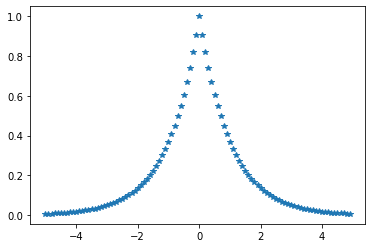

In [14]:
plot_slater()

We look at the parameters for STO-3G basis set for Hydrogen atom. For each type of orbital, the basis functions has 3 primitive gaussian functions. The output for each gaussian is of the form [α,c]

\begin{equation}
S_G(r) = \sum_j C_j e^{-\alpha_j 
r^2}
\end{equation}

For Hydrogen atom, we only have 1s orbital.

In [24]:
load('sto3g', 'H')
# # First line zero is for angular momentum

[[0,
  [3.42525091, 0.15432897],
  [0.62391373, 0.53532814],
  [0.1688554, 0.44463454]]]

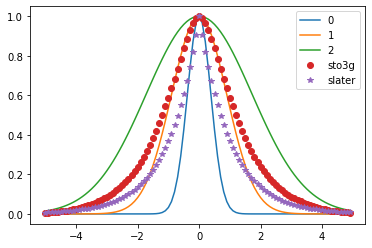

In [25]:
# plot the 3 primitive gaussian
plot_primitive_gaussian(alpha=3.42525091,label=0)
plot_primitive_gaussian(alpha=0.62391373,label=1)
plot_primitive_gaussian(alpha=0.1688554,label=2)

# plot the contracted gaussian function
plot_contracted_gaussian(load('sto3G', 'H'), label="sto3g")

# plot slater
plot_slater()

# add legends
plt.legend()

In [27]:
load('sto3g', 'C')

[[0,
  [71.616837, 0.15432897],
  [13.045096, 0.53532814],
  [3.5305122, 0.44463454]],
 [0,
  [2.9412494, -0.09996723],
  [0.6834831, 0.39951283],
  [0.2222899, 0.70011547]],
 [1,
  [2.9412494, 0.15591627],
  [0.6834831, 0.60768372],
  [0.2222899, 0.39195739]]]

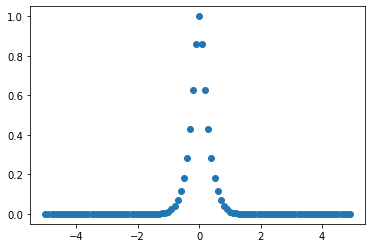

In [31]:
plot_contracted_gaussian(load('sto3g', 'C'), label = "sto3g")

In [32]:
load('3-21g', 'C')

[[0, [172.256, 0.0617669], [25.9109, 0.358794], [5.53335, 0.700713]],
 [0, [3.66498, -0.395897], [0.770545, 1.21584]],
 [0, [0.195857, 1.0]],
 [1, [3.66498, 0.23646], [0.770545, 0.860619]],
 [1, [0.195857, 1.0]]]

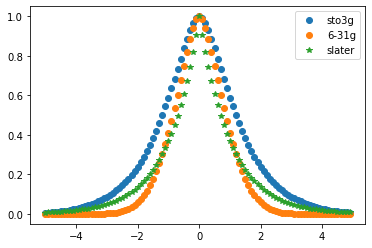

In [35]:
# comparing STO-3G and 6-31G for Hydrogen 1s orbital
plot_contracted_gaussian(load('sto3g', 'H'), label="sto3g")
plot_contracted_gaussian(load('6-31G', 'H'), label="6-31g")

plot_slater()
plt.legend()

### In cases were polarization (p/*) is needed, you can add gaussian functions of higher angular momemtum. For p-orbital you can add d-functions

In [36]:
load("6-31g*", 'C')

[[0,
  [3047.5249, 0.0018347],
  [457.36951, 0.0140373],
  [103.94869, 0.0688426],
  [29.210155, 0.2321844],
  [9.286663, 0.4679413],
  [3.163927, 0.362312]],
 [0, [7.8682724, -0.1193324], [1.8812885, -0.1608542], [0.5442493, 1.1434564]],
 [0, [0.1687144, 1.0]],
 [1, [7.8682724, 0.0689991], [1.8812885, 0.316424], [0.5442493, 0.7443083]],
 [1, [0.1687144, 1.0]],
 [2, [0.8, 1.0]]]

In [38]:
# '*' does not add p-functions to s
load("6-31g*",'H')

[[0, [18.731137, 0.0334946], [2.8253937, 0.23472695], [0.6401217, 0.81375733]],
 [0, [0.1612778, 1.0]]]

In [40]:
## To add polarization to Hydrogen atoms, you need **
load("6-31g**",'H')

[[0, [18.731137, 0.0334946], [2.8253937, 0.23472695], [0.6401217, 0.81375733]],
 [0, [0.1612778, 1.0]],
 [1, [1.1, 1.0]]]

## Geometry optimization

Similar to energy calculation we use iterative self-consistent loop to solve the Kohn-Sham equations. 

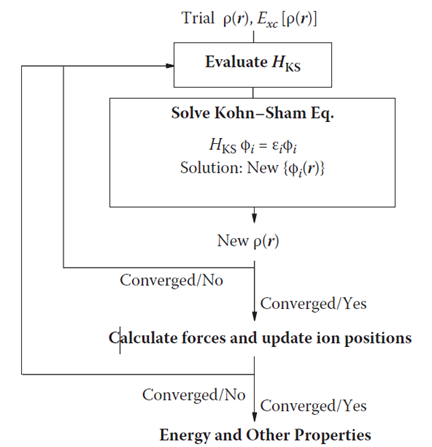

In [42]:
from pyscf.geomopt.geometric_solver import optimize

In [44]:
mol = gto.M(atom = "water.xyz")
mol.basis = "sto3g"
mf = mol.KS()
mf.xc = 'b3lyp'
mol_eq = optimize(mf)

geometric-optimize called with the following command line:
/home/user/anaconda3/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/user/.local/share/jupyter/runtime/kernel-828ec90b-e0d8-478b-b462-4e632058e3b9.json

                                        ())))))))))))))))/                     
                                    ())))))))))))))))))))))))),                
                                *)))))))))))))))))))))))))))))))))             
                        #,    ()))))))))/                .)))))))))),          
                      #%%%%,  ())))))                        .))))))))*        
                      *%%%%%%,  ))              ..              ,))))))).      
                        *%%%%%%,         ***************/.        .)))))))     
                #%%/      (%%%%%%,    /*********************.       )))))))    
              .%%%%%%#      *%%%%%%,  *******/,     **********,      .))))))   
                .%%%%%%/      *%%%%%%,  **              *


Geometry optimization cycle 1
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -0.001936   0.363984   0.000000    0.000000  0.000000  0.000000
   H  -1.252110  -0.464910   0.000000    0.000000  0.000000  0.000000
   H   0.828319  -0.181340   0.000000    0.000000  0.000000  0.000000
converged SCF energy = -75.1823821404357
--------------- SCF_Scanner gradients ---------------
         x                y                z
0 O     0.1454788782    -0.0044310475    -0.0000000000
1 H    -0.1219307777    -0.0529842623    -0.0000000000
2 H    -0.0235512079     0.0574160342    -0.0000000000
----------------------------------------------
cycle 1: E = -75.1823821404  dE = -75.1824  norm(grad) = 0.206663


Step    0 : Gradient = 1.193e-01/1.455e-01 (rms/max) Energy = -75.1823821404
Hessian Eigenvalues: 5.00000e-02 5.00000e-02 5.00000e-02 ... 1.00000e-01 1.00000e-01 4.88808e-01



Geometry optimization cycle 2
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -0.061833   0.389242   0.000000   -0.059897  0.025258  0.000000
   H  -1.119604  -0.441229   0.000000    0.132506  0.023681  0.000000
   H   0.755722  -0.230282   0.000000   -0.072597 -0.048942  0.000000

WARN: Large deviations found between the input molecule and the molecule from chkfile
Initial guess density matrix may have large error.

converged SCF energy = -75.2307724093735
--------------- SCF_Scanner gradients ---------------
         x                y                z
0 O     0.1075669902     0.0417268538     0.0000000000
1 H    -0.1107306050    -0.0661785088    -0.0000000000
2 H     0.0031604206     0.0244623629    -0.0000000000
----------------------------------------------
cycle 2: E = -75.2307724094  dE = -0.0483903  norm(grad) = 0.174817


Step    1 : Displace = 1.000e-01/1.346e-01 (rms/max) Trust = 1.000e-01 (=) Grad = 1.009e-01/1.290e-01 (rms/max) E (change) = -75.2307724094 (-4.839e-02) Quality = 1.077
Hessian Eigenvalues: 2.67262e-02 5.00000e-02 5.00000e-02 ... 5.00000e-02 1.48788e-01 6.66427e-01



Geometry optimization cycle 3
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -0.166497   0.368880  -0.000000   -0.104664 -0.020362 -0.000000
   H  -0.913920  -0.377676  -0.000000    0.205684  0.063553 -0.000000
   H   0.654726  -0.273593  -0.000000   -0.100996 -0.043311 -0.000000

WARN: Large deviations found between the input molecule and the molecule from chkfile
Initial guess density matrix may have large error.

converged SCF energy = -75.2846779848404
--------------- SCF_Scanner gradients ---------------
         x                y                z
0 O     0.0075540501     0.0235012586    -0.0000000000
1 H    -0.0178623235    -0.0165829517     0.0000000000
2 H     0.0103032125    -0.0069147495     0.0000000000
----------------------------------------------
cycle 3: E = -75.2846779848  dE = -0.0539056  norm(grad) = 0.0368429


Step    2 : Displace = 1.525e-01/2.152e-01 (rms/max) Trust = 1.414e-01 (+) Grad = 2.127e-02/2.469e-02 (rms/max) E (change) = -75.2846779848 (-5.391e-02) Quality = 0.757
Hessian Eigenvalues: 5.00000e-02 5.00000e-02 5.00000e-02 ... 1.35996e-01 1.99774e-01 6.71308e-01



Geometry optimization cycle 4
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -0.187745   0.351171   0.000000   -0.021249 -0.017709  0.000000
   H  -0.874106  -0.359595   0.000000    0.039815  0.018081  0.000000
   H   0.636337  -0.273994   0.000000   -0.018389 -0.000401  0.000000

WARN: Large deviations found between the input molecule and the molecule from chkfile
Initial guess density matrix may have large error.

converged SCF energy = -75.2839714388695
--------------- SCF_Scanner gradients ---------------
         x                y                z
0 O    -0.0360911427    -0.0223349693    -0.0000000000
1 H     0.0307798426     0.0288672366     0.0000000000
2 H     0.0053077899    -0.0065307666    -0.0000000000
----------------------------------------------
cycle 4: E = -75.2839714389  dE = 0.000706546  norm(grad) = 0.0604397


Step    3 : Displace = 3.165e-02/4.389e-02 (rms/max) Trust = 2.000e-01 (+) Grad = 3.489e-02/4.244e-02 (rms/max) E (change) = -75.2839714389 (+7.065e-04) Quality = -0.422
Hessian Eigenvalues: 5.00000e-02 5.00000e-02 5.00000e-02 ... 1.44220e-01 5.03929e-01 6.50598e-01



Geometry optimization cycle 5
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -0.172126   0.360823   0.000000    0.015619  0.009653  0.000000
   H  -0.892563  -0.370061   0.000000   -0.018458 -0.010466  0.000000
   H   0.639197  -0.273203   0.000000    0.002860  0.000791  0.000000

WARN: Large deviations found between the input molecule and the molecule from chkfile
Initial guess density matrix may have large error.

converged SCF energy = -75.2855238034573
--------------- SCF_Scanner gradients ---------------
         x                y                z
0 O    -0.0026685268     0.0022551840    -0.0000000000
1 H     0.0020926353     0.0000420133    -0.0000000000
2 H     0.0005725129    -0.0022949392     0.0000000000
----------------------------------------------
cycle 5: E = -75.2855238035  dE = -0.00155236  norm(grad) = 0.00470981


Step    4 : Displace = 1.620e-02/2.161e-02 (rms/max) Trust = 1.582e-02 (-) Grad = 2.719e-03/3.494e-03 (rms/max) E (change) = -75.2855238035 (-1.552e-03) Quality = 0.903
Hessian Eigenvalues: 5.00000e-02 5.00000e-02 5.00000e-02 ... 1.47314e-01 5.53804e-01 6.27108e-01



Geometry optimization cycle 6
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -0.171772   0.356916   0.000000    0.000354 -0.003908  0.000000
   H  -0.898547  -0.369415   0.000000   -0.005984  0.000646  0.000000
   H   0.644934  -0.270002   0.000000    0.005738  0.003200  0.000000

WARN: Large deviations found between the input molecule and the molecule from chkfile
Initial guess density matrix may have large error.

converged SCF energy = -75.2855344833666
--------------- SCF_Scanner gradients ---------------
         x                y                z
0 O    -0.0015557192     0.0001908884     0.0000000000
1 H    -0.0007853355     0.0004795543    -0.0000000000
2 H     0.0023358284    -0.0006674492     0.0000000000
----------------------------------------------
cycle 6: E = -75.2855344834  dE = -1.06799e-05  norm(grad) = 0.00303398


Step    5 : Displace = 5.584e-03/6.411e-03 (rms/max) Trust = 2.238e-02 (+) Grad = 1.752e-03/2.429e-03 (rms/max) E (change) = -75.2855344834 (-1.068e-05) Quality = 0.430
Hessian Eigenvalues: 4.99989e-02 5.00000e-02 5.00000e-02 ... 2.75003e-01 4.93182e-01 5.91073e-01



Geometry optimization cycle 7
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -0.170784   0.358025   0.000000    0.000988  0.001109 -0.000000
   H  -0.896223  -0.369806   0.000000    0.002324 -0.000391 -0.000000
   H   0.641751  -0.270795   0.000000   -0.003183 -0.000792 -0.000000
converged SCF energy = -75.2855441572987
--------------- SCF_Scanner gradients ---------------
         x                y                z
0 O     0.0001170912     0.0002181362     0.0000000000
1 H    -0.0001562884    -0.0001736788     0.0000000000
2 H     0.0000348703    -0.0000418019    -0.0000000000
----------------------------------------------
cycle 7: E = -75.2855441573  dE = -9.67393e-06  norm(grad) = 0.000344743


Step    6 : Displace = 2.460e-03/3.164e-03 (rms/max) Trust = 2.238e-02 (=) Grad = 1.990e-04/2.476e-04 (rms/max) E (change) = -75.2855441573 (-9.674e-06) Quality = 1.001
Hessian Eigenvalues: 4.99959e-02 5.00000e-02 5.00000e-02 ... 2.81594e-01 5.08350e-01 5.59151e-01



Geometry optimization cycle 8
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -0.170787   0.357908   0.000000   -0.000003 -0.000118 -0.000000
   H  -0.896087  -0.369749   0.000000    0.000136  0.000057 -0.000000
   H   0.641756  -0.270818   0.000000    0.000005 -0.000023 -0.000000
converged SCF energy = -75.2855442179946
--------------- SCF_Scanner gradients ---------------
         x                y                z
0 O     0.0000013590     0.0000463481    -0.0000000000
1 H    -0.0000171396    -0.0000266586     0.0000000000
2 H     0.0000114475    -0.0000170405    -0.0000000000
----------------------------------------------
cycle 8: E = -75.285544218  dE = -6.06959e-08  norm(grad) = 5.97985e-05


Step    7 : Displace = 9.540e-05/1.205e-04 (rms/max) Trust = 3.165e-02 (+) Grad = 3.452e-05/4.637e-05 (rms/max) E (change) = -75.2855442180 (-6.070e-08) Quality = 1.146
Hessian Eigenvalues: 4.99959e-02 5.00000e-02 5.00000e-02 ... 2.81594e-01 5.08350e-01 5.59151e-01
Converged! =D

    #==========================================================================#
    #| If this code has benefited your research, please support us by citing: |#
    #|                                                                        |#
    #| Wang, L.-P.; Song, C.C. (2016) "Geometry optimization made simple with |#
    #| translation and rotation coordinates", J. Chem, Phys. 144, 214108.     |#
    #| http://dx.doi.org/10.1063/1.4952956                                    |#
    #==========================================================================#
    Time elapsed since start of run_optimizer: 2.284 seconds


In [45]:
# save the optimized geometry for visualization
mol_eq.tofile("opt_water.xyz")

'3\nXYZ from PySCF\nO          -0.17079        0.35791        0.00000\nH          -0.89609       -0.36975        0.00000\nH           0.64176       -0.27082        0.00000'

### We can set the convergence criterion

In [46]:
conv_params = {
    'convergence_energy': 1e-1,  # Eh
    'convergence_grms': 3e-1,    # Eh/Bohr
    'convergence_gmax': 4.5e-1,  # Eh/Bohr
    'convergence_drms': 1.2e-1,  # Angstrom
    'convergence_dmax': 1.8e-1,  # Angstrom
}

mol_eq = optimize(mf, **conv_params)


geometric-optimize called with the following command line:
/home/user/anaconda3/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/user/.local/share/jupyter/runtime/kernel-828ec90b-e0d8-478b-b462-4e632058e3b9.json

                                        ())))))))))))))))/                     
                                    ())))))))))))))))))))))))),                
                                *)))))))))))))))))))))))))))))))))             
                        #,    ()))))))))/                .)))))))))),          
                      #%%%%,  ())))))                        .))))))))*        
                      *%%%%%%,  ))              ..              ,))))))).      
                        *%%%%%%,         ***************/.        .)))))))     
                #%%/      (%%%%%%,    /*********************.       )))))))    
              .%%%%%%#      *%%%%%%,  *******/,     **********,      .))))))   
                .%%%%%%/      *%%%%%%,  **              *


Geometry optimization cycle 1
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -0.001936   0.363984   0.000000    0.000000  0.000000  0.000000
   H  -1.252110  -0.464910   0.000000    0.000000  0.000000  0.000000
   H   0.828319  -0.181340   0.000000    0.000000  0.000000  0.000000
converged SCF energy = -75.1823821404357
--------------- SCF_Scanner gradients ---------------
         x                y                z
0 O     0.1454788782    -0.0044310475    -0.0000000000
1 H    -0.1219307777    -0.0529842623    -0.0000000000
2 H    -0.0235512079     0.0574160342     0.0000000000
----------------------------------------------
cycle 1: E = -75.1823821404  dE = -75.1824  norm(grad) = 0.206663


Step    0 : Gradient = 1.193e-01/1.455e-01 (rms/max) Energy = -75.1823821404
Hessian Eigenvalues: 5.00000e-02 5.00000e-02 5.00000e-02 ... 1.00000e-01 1.00000e-01 4.88808e-01



Geometry optimization cycle 2
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -0.061833   0.389242   0.000000   -0.059897  0.025258  0.000000
   H  -1.119604  -0.441229   0.000000    0.132506  0.023681  0.000000
   H   0.755722  -0.230282   0.000000   -0.072597 -0.048942  0.000000

WARN: Large deviations found between the input molecule and the molecule from chkfile
Initial guess density matrix may have large error.

converged SCF energy = -75.2307724093734
--------------- SCF_Scanner gradients ---------------
         x                y                z
0 O     0.1075669902     0.0417268538     0.0000000000
1 H    -0.1107306050    -0.0661785088    -0.0000000000
2 H     0.0031604206     0.0244623629     0.0000000000
----------------------------------------------
cycle 2: E = -75.2307724094  dE = -0.0483903  norm(grad) = 0.174817


Step    1 : Displace = 1.000e-01/1.346e-01 (rms/max) Trust = 1.000e-01 (=) Grad = 1.009e-01/1.290e-01 (rms/max) E (change) = -75.2307724094 (-4.839e-02) Quality = 1.077
Hessian Eigenvalues: 5.00000e-02 5.00000e-02 5.00000e-02 ... 1.00000e-01 1.00000e-01 4.88808e-01
Converged! =D

    #==========================================================================#
    #| If this code has benefited your research, please support us by citing: |#
    #|                                                                        |#
    #| Wang, L.-P.; Song, C.C. (2016) "Geometry optimization made simple with |#
    #| translation and rotation coordinates", J. Chem, Phys. 144, 214108.     |#
    #| http://dx.doi.org/10.1063/1.4952956                                    |#
    #==========================================================================#
    Time elapsed since start of run_optimizer: 0.785 seconds


## Frequency calculation
Running frequency calculation is one way to find out whether the optimzation reached an energy minima. Remember we only used the first derivative (gradient) for convergence check. The frequency calculations get the second derrivative (hessian) which will tell us whether it is a maxima (negative values for frequency) or minima (positive values) on the energy surface



In [47]:
# create a molecule object
mol = gto.M(atom="opt_water.xyz")

# set basis set
mol.basis = "sto3g"

# set the functional
mf = mol.KS()
mf.xc = 'b3lyp'

# run frequency calculation
mf.run()
hessian = mf.Hessian().kernel()

converged SCF energy = -75.2855442175509


In [48]:
from pyscf.hessian import thermo

# getting the frequncy data from the calculation
freq_info = thermo.harmonic_analysis(mf.mol, hessian)
freq_info["freq_wavenumber"]

array([2016.69800977, 3610.43986799, 3834.7065054 ])